In [8]:
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
import dash_bootstrap_components as dbc

from dash.dependencies import Input, Output
import dash_table

from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import time
import json

import plotly.graph_objects as go

import seaborn as sns

import os
import re 

from networkx.readwrite import json_graph
from scipy.stats import mode
import networkx as nx
import json
import ast


def load_db_credentials():
    '''Load database credentials from bash_profile'''

    user = os.environ['db_user']
    password = os.environ['db_pass']
    server = os.environ['db_host']
    database = os.environ['db_name']

    return user, password, server, database

from data_processing import *

from datetime import datetime, date
from dateutil.relativedelta import relativedelta

def check_late_birthday(date_of_birth):

    try:
        dt = datetime.strptime(date_of_birth, '%Y-%m-%d')
        draft = date(dt.year + 18, 9, 15)
        if relativedelta(draft, dt).years < 18 :
            return True
        else:
            return False

    except:
        return None

In [10]:
# load database credentials and create connection
user, password, server, database = load_db_credentials()
engine = create_engine(f'postgresql://{user}:{password}@{server}:5432/{database}')

player_value = pd.read_sql(f'''select * from summary_projections ''', con=engine)
projections = pd.read_sql(f'''select * from projections ''', con=engine)
dataset = pd.read_csv('../data/player_season_stats_v2.csv')

In [5]:
def rankings_background_color_bins(df, n_bins=5, columns='all', group='league', ascending=False):

    bounds = [i * (1.0 / n_bins) for i in range(n_bins + 1)]

    if columns == 'all':
        if 'id' in df:
            df_numeric_columns = df.select_dtypes('number').drop(['id'], axis=1)
        else:
            df_numeric_columns = df.select_dtypes('number')
    else:
        df_numeric_columns = df[columns]
        
    if ascending:
        low_color = 40
        high_color = 218
    
    else:
        low_color = 218
        high_color = 40      
        

    styles = []
    legend = []
    
    for position in df.primary_position.unique():
        
        subset = df[df.primary_position == position]

        for column in df_numeric_columns:

            for i in range(1, len(bounds)):
                min_bound = np.percentile(subset[column], bounds[i - 1] * 100)
                max_bound = np.percentile(subset[column], bounds[i] * 100)
                backgroundColor = custom_plotly_colorscale(sns.diverging_palette(high_color, low_color, s=72, l=69, n=n_bins), n_bins)[i - 1][1]
                color = 'black' 

                styles.append({
                    'if': {
                        'filter_query': (
                            '{{position}} = "{pos}"  && ' + 
                            '{{{column}}} >= {min_bound}' +
                            (' && {{{column}}} < {max_bound}' if (i < len(bounds) - 1) else '')
                        ).format(pos=position, column=column, min_bound=min_bound, max_bound=max_bound),
                        'column_id': column
                    },
                    'backgroundColor': backgroundColor,
                    'color': color,
                })

                legend.append(
                    html.Div(style={'display': 'inline-block', 'width': '60px'}, children=[
                        html.Div(
                            style={
                                'backgroundColor': backgroundColor,
                                'borderLeft': '1px rgb(50, 50, 50) solid',
                                'height': '10px',
                            }
                        ),
                        html.Small(round(bounds[i - 1] * 100), style={'paddingLeft': '2px'})
                    ])
                )

    return (styles, html.Div(legend, style={'padding': '5px 0 5px 0'}))


def legend_background_color_bins(df, n_bins=5, columns='all'):
    
    bounds = [i * (1.0 / n_bins) for i in range(n_bins + 1)]

    if columns == 'all':
        if 'id' in df:
            df_numeric_columns = df.select_dtypes('number').drop(['id'], axis=1)
        else:
            df_numeric_columns = df.select_dtypes('number')
    else:
        df_numeric_columns = df[columns]

    styles = []
    legend = []
    
    for column in df_numeric_columns:

        for i in range(1, len(bounds)):
            min_bound = np.percentile(df[column], bounds[i - 1] * 100)
            max_bound = np.percentile(df[column], bounds[i] * 100)
            backgroundColor = custom_plotly_colorscale(sns.diverging_palette(40, 218, s=72, l=69, n=n_bins), n_bins)[i - 1][1]
            color = 'black' 

            styles.append({
                'if': {
                    'filter_query': (
                        '{{{column}}} >= {min_bound}' +
                        (' && {{{column}}} < {max_bound}' if (i < len(bounds) - 1) else '')
                    ).format(column=column, min_bound=min_bound, max_bound=max_bound),
                    'column_id': column
                },
                'backgroundColor': backgroundColor,
                'color': color,
            })

            legend.append(
                html.Div(style={'display': 'inline-block', 'width': '60px'}, children=[
                    html.Div(
                        style={
                            'backgroundColor': backgroundColor,
                            'borderLeft': '1px rgb(50, 50, 50) solid',
                            'height': '10px',
                        }
                    ),
                    html.Small(round(bounds[i - 1] * 100), style={'paddingLeft': '2px'})
                ])
            )

    return (styles, html.Div(legend, style={'padding': '5px 0 5px 0'}))

def custom_plotly_colorscale(c, bins=7):

    h = 1.0/(bins-1)
    pl_colorscale = []
    
    for k in range(bins):
        pl_colorscale.append([k*h, 'rgb'+str((c[k][0]*255, c[k][1]*255, c[k][2]*255))])
        
    return pl_colorscale

from scipy import stats

def get_value_rank(data):
            
    df = draft_plus5[(draft_plus5.primary_position == data.primary_position)]
    
    return stats.percentileofscore(df.draft_plus_5_points, data.nhl_expected_value)

def get_ceiling_rank(data):
            
    df = draft_plus5[(draft_plus5.primary_position == data.primary_position)]
    
    return stats.percentileofscore(df.draft_plus_5_points, data.nhl_ceiling)
        
def calc_draft_value(data):
    
    if data.late_birthday.sum() > 0:
        
        return pd.Series({
            'draft_plus_5_points' : (data[(data.season_age >= 20) 
                                         & (data.season_age <= 24)
                                         & (data.league == 'NHL')].tp /\
                                    data[(data.season_age >= 20) 
                                         & (data.season_age <= 24)
                                         & (data.league == 'NHL')].deflator).sum(),
            'draft_plus_5_gp' : data[(data.season_age >= 20) 
                                   & (data.season_age <= 24)
                                   & (data.league == 'NHL')].gp.sum()
                         })
    
    else:
        return pd.Series({
            'draft_plus_5_points' : (data[(data.season_age >= 19) 
                                         & (data.season_age <= 23)
                                         & (data.league == 'NHL')].tp /\
                                    data[(data.season_age >= 19) 
                                         & (data.season_age <= 23)
                                         & (data.league == 'NHL')].deflator).sum(),
            'draft_plus_5_gp' : data[(data.season_age >= 19) 
                                   & (data.season_age <= 23)
                                   & (data.league == 'NHL')].gp.sum()})

from datetime import datetime  
def get_current_year():
    
    today = datetime.today()
    
    if today.month > 11:
        return today.year + 1
    
    else:
        return today.year
    
def get_imperial_height(data):
    
    import math
    
    feet = f'''{math.floor(data * 0.0328)}' '''
    inches = f'''{int((data - (math.floor(data * 0.0328) / 0.0328)) * 0.3937)}" '''
    
    return "".join([feet, inches])

def get_primary_position(val):

    match = re.search('[c,w,lw,rw,f]', val.lower())

    if match:
        return 'F'
    else:
        return 'D'
    
def extract_rankings_from_text(text):
    try:
        text_string=re.findall("[0-9]+",text)
        rankings=list(map(int,text_string))
        avg_rankings=sum(rankings)/len(rankings)
        return int(avg_rankings)
    except TypeError:
        return np.NaN
    
def nhl_expected_gp(G, node):
        
    return np.sum([gp_dict[G.nodes[node]['league']] * G.nodes[node]['cond_prob'] if G.nodes[node]['league'] == 'NHL' else 0] + \
                [gp_dict[G.nodes[n]['league']] * G.nodes[n]['cond_prob']\
                   for n in nx.descendants(G, node) if G.nodes[n]['league'] == 'NHL']).round(1)

def get_expected_gp(data):
    
    try:
        G = json_graph.node_link_graph(json.loads(data['graph'].item()))
        
    except:
        G = json_graph.node_link_graph(json.loads(data['graph']))
        
    nodes = [end for start,end in G.edges if start == 1]
        
    return round(sum([nhl_expected_gp(G, n) for n in nodes]))


# X = dataset[(dataset.gp < 85)
#             & (dataset.season_age >= 19)
#             & (dataset.season_age <= 24)
#             & (dataset.league == 'NHL')]

# team_mask = dataset.team.apply(lambda x : len(ast.literal_eval(x)) > 1)

# gp_dict = dataset[(dataset.gp < 85)
#                        & (dataset.season_age >= 17)
#                        & ~(team_mask)
#                        & (dataset.season_age <= 24)].groupby('league').gp.apply(
#     lambda x: mode(x)[0][0]).round().to_dict()

# scoring = dataset[dataset.league == 'NHL'].groupby('year').g.sum() / \
# dataset[dataset.league == 'NHL'].groupby('year').gp.sum()

# scoring = scoring.rename('deflator').to_frame()

# scoring['deflator'] /= (scoring.loc[scoring.index.max()].item())

# X = X.merge(scoring, on = 'year')

# X['tp'] /= X.deflator



# df = draft_plus5[(draft_plus5['draft_round'] <= 7)
#                  & (draft_plus5['draft_year'] <= 2015)
#                 ][[
#     'playerid', 'draft_year', 'draft_round', 'draft_pick', 
#     'draft_plus_5_points', 'draft_plus_5_gp']].merge(
#     player_value[player_value.base_year == 'DY'][[
#         "playerid", "player_name", "position", "nhl_likelihood", 'nhl_ceiling',
#         "most_likely_nhl_prob", "nhl_ceiling_prob", "nhl_expected_value" ]],
#     on='playerid',
# #     how='left'
# )

In [6]:
def get_draft_rankings(draft_year=2020):

    # load database credentials and create connection
    user, password, server, database = load_db_credentials()
    engine = create_engine(f'postgresql://{user}:{password}@{server}:5432/{database}')

    player_value = pd.read_sql(f'''select * from summary_projections where draft_year = {draft_year} and base_year = 'DY'  ''', con=engine)
    player_value['playerid'] = player_value['playerid'].astype(str)

    #     projections = pd.read_sql(f'''select * from projections where draft_year = {draft_year} and base_year = 'DY' ''', con=engine)
    #     dataset = pd.read_csv('../data/player_season_stats_v2.csv')
    dataset =  pd.read_sql(f'''select distinct playerid, player, gp, g, a, tp, ppg, position, year, team, league  from skater_stats order by gp desc ''', con=engine)
    dataset['primary_position'] = dataset.position.apply(get_primary_position)
    info = pd.read_sql(f''' select * from player_info where catches is NULL and draft_year = '{draft_year}' ''', engine)
    
        
    # era adjust scoring
    scoring = dataset.groupby(['league', 'year']).g.sum() / \
                dataset.groupby(['league', 'year']).gp.sum()

    scoring = scoring.rename('deflator').to_frame()

    scoring = scoring.merge(scoring[scoring.index.get_level_values('year') == '2019-2020'],
                  on='league',
                  suffixes=('', '_base'),
                  how='left').set_index(scoring.index)

    scoring['deflator'] /= scoring['deflator_base']
    
    # add height weight to player df
    player_value = player_value.merge(info[['playerid', 'height', 'weight', 'rights', 'nation',
                                            'nhl_draft', 'shoots', 'draft_pick', 'draft_round']],
                                    on = ['playerid']
                                     )
    # merge player information with player seasons
    dataset = dataset.merge(
        info[info.date_of_birth.notnull()].drop('position', axis=1), 
        on = ['playerid'],
        how = 'right'
    )

    dataset['primary_position'] = dataset.position.apply(get_primary_position)
    dataset['late_birthday'] = dataset.date_of_birth.apply(check_late_birthday)

    # get season age per player season
    dataset['start_year'], dataset['end_year']  = zip(*dataset['year'].apply(lambda x : x.split('-')))
    dataset = get_season_age(dataset)
    # dataset['playerid'] = dataset['playerid'].astype(int)

    draft_elg = dataset[((dataset.draft_pick.notnull())
                         & (dataset.end_year == str(draft_year))
                         & (dataset.draft_year == str(draft_year)))].drop_duplicates(subset=['playerid', 'player'])

    dataset = dataset.merge(scoring, on = ['league', 'year'])

    agg = dataset[dataset.playerid.isin(player_value.playerid)].groupby(['playerid']).apply(calc_draft_value).reset_index()

    draft_elg = draft_elg.merge(agg,
                                on='playerid',
                                how='right'
                               )

    df = draft_elg[['playerid', 'league', 'gp', 'g', 'a', 'tp',
                    'real_season_age', 'draft_plus_5_points', 'draft_plus_5_gp'
                   ]].merge(
        player_value[["playerid", "player_name", "position", 'height', 'weight', 'graph',
                       'shoots', 'draft_year', 'draft_pick', 'draft_round', 'nhl_maximizing_node',
                      "nhl_likelihood", 'nhl_ceiling', 'nhl_floor', 'most_likely_nhl_node',
                    "most_likely_nhl_prob", "nhl_ceiling_prob", "nhl_expected_value" ]],
        on='playerid',
        how='right'
    )

    #     df['APPLE Rank'] = df.groupby('position').nhl_expected_value.rank(ascending=False).astype(int)
    #     df['Avg. Rank'] = df.rankings.apply(extract_rankings_from_text)

    df['weight'] = (df.weight * 2.2).astype(int)
    df['height'] = df.height.apply(get_imperial_height)

    df['real_season_age'] = df['real_season_age'].round(1)

    #     df['nhl_expected_value'] = df['nhl_expected_value'].astype(int)

    df['primary_position'] = df.position

    df['xvalue_percentile'] = df.apply(get_value_rank, axis=1)
    df['ceiling_percentile'] = df.apply(get_ceiling_rank, axis=1)
    #     df.sort_values('historical_percentile', ascending=False, inplace=True)

    #     df['historical_percentile'] = df['historical_percentile'].rank(ascending=False).astype(int)

    df['draft_plus_5_points'] = df['draft_plus_5_points'].fillna(0)
    df['draft_plus_5_gp'] = df['draft_plus_5_gp'].fillna(0)
    df['nhl_expected_value'] = df['nhl_expected_value'].fillna(0)
    
    return df[df.position.notnull()]

In [11]:
### using era-adjusted points
dataset['playerid'] = dataset.playerid.astype(str)
dataset['primary_position'] = dataset.position.apply(get_primary_position)
dataset['late_birthday'] = dataset.date_of_birth.apply(check_late_birthday)

draft_plus5 = dataset.groupby(['playerid', 'player', 'draft_year', 
                         'draft_round', 'draft_pick','primary_position']).apply(calc_draft_value).reset_index()

draft_plus5['playerid'] = draft_plus5['playerid'].astype(int)

In [12]:
drafted = pd.concat([get_draft_rankings(year) for year in range(2006,2021)])

In [ ]:
drafted['draft_year'] = drafted['draft_year'].astype(int)
df = drafted[(drafted['draft_year'] <= 2015)]
df = df[df.position.notnull()]

In [ ]:
df=drafted.copy()

### compare difference in draft dataframes

In [951]:
draft1[draft1.player_name == 'William Nylander']

,playerid,draft_year,draft_round,draft_pick,draft_plus_5_points,draft_plus_5_gp,player_name,position,nhl_likelihood,nhl_ceiling,most_likely_nhl_prob,nhl_ceiling_prob,nhl_expected_value
992,38703,2014.0,1.0,8.0,155.98216,217.0,William Nylander,F,0.98,260.0,0.38,0.23,172


In [950]:
draft2[draft2.player_name == 'William Nylander']

,playerid,league,gp,g,a,tp,real_season_age,draft_plus_5_points,draft_plus_5_gp,player_name,position,height,weight,shoots,draft_year,draft_pick,draft_round,nhl_likelihood,nhl_ceiling,nhl_floor,most_likely_nhl_prob,nhl_ceiling_prob,nhl_expected_value,primary_position,xvalue_percentile,ceiling_percentile
80,38703,SHL,22.0,1.0,6.0,7.0,18.7,170.20122,239.0,William Nylander,F,"5' 11""",195,R,2014,8,1,0.98,260.0,180,0.38,0.23,172,F,98.315789,99.24812


In [727]:
### adjusted scoring

In [ ]:
#9324 JVR doesn't appear in second

In [979]:
px.scatter(data_frame=df,
           x='nhl_expected_value',
           y='draft_plus_5_points',
           trendline='ols',
           color='position',
           facet_col='position'
          )

## How well do NHL teams draft players

#### average rank: average rank of the group

In [955]:
df['draft_pick'] = df['draft_pick'].astype(int)

In [956]:
df['apple_rank'] = df.groupby(['position', 'draft_year'])['nhl_expected_value'].rank(method='average', ascending=False).astype(int)
df['nhl_rank'] = df.groupby(['position', 'draft_year'])['draft_plus_5_points'].rank(method='average', ascending=False).astype(int)

In [957]:
df.groupby(['position'])[['draft_pick', 'nhl_rank']].corr(method='spearman')

draft_pick  nhl_rank
position                                 
D        draft_pick    1.000000  0.467083
         nhl_rank      0.467083  1.000000
F        draft_pick    1.000000  0.502281
         nhl_rank      0.502281  1.000000

In [958]:
px.scatter(data_frame=df[df.position.notnull()],
           x='draft_pick',
           y='nhl_rank',
         facet_col='position',
         trendline="ols",
          )

In [959]:
df.groupby(['position'])[['apple_rank', 'nhl_rank']].corr(method='spearman')

apple_rank  nhl_rank
position                                 
D        apple_rank    1.000000  0.505825
         nhl_rank      0.505825  1.000000
F        apple_rank    1.000000  0.512541
         nhl_rank      0.512541  1.000000

In [960]:
px.scatter(data_frame=df[df.position.notnull()],
           x='apple_rank',
           y='nhl_rank',
         facet_col='position',
         trendline="ols",
           hover_data=['player_name']
          )

#### dense rank: like ‘min’, but rank always increases by 1 between groups.


In [961]:
df['apple_rank'] = df.groupby(['position', 'draft_year'])['nhl_expected_value'].rank(method='dense', ascending=False).astype(int)
df['nhl_rank'] = df.groupby(['position', 'draft_year'])['draft_plus_5_points'].rank(method='dense', ascending=False).astype(int)

In [962]:
df.groupby(['position'])[['draft_pick', 'nhl_rank']].corr(method='spearman')

draft_pick  nhl_rank
position                                 
D        draft_pick    1.000000  0.377924
         nhl_rank      0.377924  1.000000
F        draft_pick    1.000000  0.479407
         nhl_rank      0.479407  1.000000

In [963]:
px.scatter(data_frame=df[df.position.notnull()],
           x='draft_pick',
           y='nhl_rank',
         facet_col='position',
         trendline="ols",
          )

In [818]:
df.groupby(['position'])[['apple_rank', 'nhl_rank']].corr(method='spearman')

apple_rank  nhl_rank
position                                 
D        apple_rank    1.000000  0.617212
         nhl_rank      0.617212  1.000000
F        apple_rank    1.000000  0.587849
         nhl_rank      0.587849  1.000000

In [964]:
px.scatter(data_frame=df[df.position.notnull()],
           x='apple_rank',
           y='nhl_rank',
         facet_col='position',
         trendline="ols",
          )

In [3]:
df['picks'] = 1

draft = df.groupby(['position', 'nhl_rank'])['gp', 'draft_plus_5_points', 'picks',
                                       'nhl_ceiling', 'nhl_likelihood', 'most_likely_nhl_prob', 
                                       'nhl_ceiling_prob', 'nhl_expected_value'].sum().reset_index()

draft['gp'] /= draft.picks
draft['draft_plus_5_points'] /= draft.picks
draft['nhl_likelihood'] /= draft.picks
draft['most_likely_nhl_prob'] /= draft.picks
draft['nhl_ceiling_prob'] /= draft.picks
draft['nhl_expected_value'] /= draft.picks
draft['nhl_ceiling'] /= draft.picks

draft_['gp'] /= draft_.picks
draft_['draft_plus_5_points'] /= draft_.picks
draft_['nhl_likelihood'] /= draft_.picks
draft_['most_likely_nhl_prob'] /= draft_.picks
draft_['nhl_ceiling_prob'] /= draft_.picks
draft_['nhl_expected_value'] /= draft_.picks
draft_['nhl_ceiling'] /= draft_.picks


draft_ = df.groupby(['position', 'apple_rank'])['gp', 'draft_plus_5_points', 'picks',
                                       'nhl_ceiling', 'nhl_likelihood', 'most_likely_nhl_prob', 
                                       'nhl_ceiling_prob', 'nhl_expected_value'].sum().reset_index()

draft = df.groupby(['position', 'draft_pick'])['gp', 'draft_plus_5_points', 'picks',
                                       'nhl_ceiling', 'nhl_likelihood', 'most_likely_nhl_prob', 
                                       'nhl_ceiling_prob', 'nhl_expected_value'].mean().reset_index()


NameError: name 'df' is not defined

In [966]:
px.scatter(draft, x="draft_pick", y="draft_plus_5_points", color='position', facet_col='position')

In [967]:
px.scatter(draft, x="draft_pick", y="nhl_expected_value", color='position', facet_col='position')

In [968]:
px.scatter(df,
           x="draft_pick",
           y="nhl_expected_value",
           color='position',
          facet_col='position')

In [969]:
px.scatter(df,
           x="draft_pick",
           y="draft_plus_5_points",
           color='position',
          facet_col='position')

In [970]:
import powerlaw
results = powerlaw.Fit(draft[draft.position == 'F'].draft_plus_5_points)
expected = powerlaw.Fit(draft[draft.position == 'F'].nhl_expected_value)

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


In [971]:
y, x = results.ccdf(original_data=True)
y_, x_ = expected.ccdf(original_data=True)

In [972]:
d1 = go.Scatter(x=[round(val* 210) for val in x], y=y, name='Actual', marker=dict(color='black'))
d2 = go.Scatter(x=[round(val* 210) for val in x_], y=y_, name='Expected',marker=dict(color='blue'))

In [973]:
go.Figure(data=[d1,d2])

### Expected Pick Value

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pickle

def func(x, a, b, c):
    return a * np.exp(-b * x) + c

def inverse_exp(x, a, b, c):

    return np.log((x - c) / a) / -b

def fit_draft_curve(data):
    
    y = data.nhl_expected_value
    x = data.draft_pick
    
    popt, pcov = curve_fit(func,
                       x,
                       y)
    
    return popt

def get_draft_value(data, clusters):
    
    X = data[['nhl_expected_value', 'xpick']]
    
    kmeans = KMeans(n_clusters=clusters).fit(X)
    
    return kmeans

    
def get_draft_upside(data, clusters):
    
    X = data[['nhl_ceiling', 'ceiling_percentile']]
    
    kmeans = KMeans(n_clusters=clusters).fit(X)
    
    return kmeans

def get_cluster_labels(data, cluster, labels, c_type = 'value'):
    
    df = data.groupby([cluster])['nhl_expected_value' if c_type == 'value' \
                                 else 'nhl_ceiling'].mean().sort_values(ascending=False)
        
    return {k:v for k,v in zip(df.index, labels[c_type]['labels'])}
    
    
cluster_labels = {
    'F' : {
        'value' : {
            'num_cluster' : 7,
            'labels' : ['Franchise', 'Top 5', 'Top 15', '1st Round', '2nd-3rd Round', 'Mid Round', 'Late Round']
        },
        'upside' : {
            'num_cluster' : 6,
            'labels' : ['Top End', 'High End', 'Mid End', 'Safe', 'Project', 'Unknown']
        }
    },
    'D' : {
        'value' : {
            'num_cluster' : 7,
            'labels' : ['Top 5', 'Top 15', '1st Round', '2nd round', '3rd Round', 'Mid Round', 'Late Round']
        },
        'upside' : {
            'num_cluster' : 6,
            'labels' : ['Top End', 'High End', 'Mid End', 'Safe', 'Project', 'Unknown']
        }
    }
}

f_params = fit_draft_curve(draft[draft.position == 'F']) # 224.75603480181096, 0.06324523838602378, 2.542136232484409
d_params = fit_draft_curve(draft[draft.position == 'D']) # 101.8852594934708, 0.0542482743796363, 1.5254264511302613

df['xpick'] = np.nan_to_num(np.where(df.position == 'F',
                                inverse_exp(df.nhl_expected_value, *f_params),
                                inverse_exp(df.nhl_expected_value, *d_params)
                                          ),
                                  nan=150)

fwd = df[df.position == 'F']
def_ = df[df.position == 'D']

f_draft_value = get_draft_value(fwd, cluster_labels['F']['value']['num_cluster'])
f_draft_upside = get_draft_upside(fwd, cluster_labels['F']['upside']['num_cluster'])
d_draft_value = get_draft_value(def_, cluster_labels['D']['value']['num_cluster'])
d_draft_upside = get_draft_upside(def_, cluster_labels['D']['upside']['num_cluster'])

pickle.dump(f_draft_value, open("../models/forward_value_kmeans.pkl", "wb"))
pickle.dump(f_draft_upside, open("../models/forward_upside_kmeans.pkl", "wb"))
pickle.dump(d_draft_value, open("../models/defence_value_kmeans.pkl", "wb"))
pickle.dump(d_draft_upside, open("../models/defence_upside_kmeans.pkl", "wb"))


NameError: name 'draft' is not defined

In [1386]:
df = pd.concat([get_draft_rankings(year) for year in range(2006,2021)])

df['xpick'] = np.nan_to_num(np.where(df.position == 'F',
                                inverse_exp(df.nhl_expected_value, *f_params),
                                inverse_exp(df.nhl_expected_value, *d_params)
                                          ),
                                  nan=150)

df['xpick_value'] = np.where(df.position == 'F',
                       func(df.draft_pick.astype(float), *f_params),
                       func(df.draft_pick.astype(float), *d_params)
                                          )

In [1343]:
f_draft_value = pickle.load(open("../models/forward_value_kmeans.pkl", "rb"))
f_draft_upside = pickle.load(open("../models/forward_upside_kmeans.pkl", "rb"))
d_draft_value = pickle.load(open("../models/defence_value_kmeans.pkl", "rb"))
d_draft_upside = pickle.load(open("../models/defence_upside_kmeans.pkl", "rb"))

In [1344]:
fwd = df[df.position == 'F']
def_ = df[df.position == 'D']

In [1358]:
fwd['value_cluster'] = f_draft_value.predict(fwd[['nhl_expected_value', 'xpick']])
fwd['upside_cluster'] = f_draft_upside.predict(fwd[['nhl_ceiling', 'ceiling_percentile']])
def_['value_cluster'] = d_draft_value.predict(def_[['nhl_expected_value', 'xpick']])
def_['upside_cluster'] = d_draft_upside.predict(def_[['nhl_ceiling', 'ceiling_percentile']])

In [1359]:
fwd['draft_value_range'] = fwd.value_cluster.map(
    get_cluster_labels(fwd, 'value_cluster', cluster_labels['F']))

fwd['draft_upside'] = fwd.upside_cluster.map(
    get_cluster_labels(fwd, 'upside_cluster', cluster_labels['F'], 'upside'))

def_['draft_value_range'] = def_.value_cluster.map(
    get_cluster_labels(def_, 'value_cluster', cluster_labels['D']))

def_['draft_upside'] = def_.upside_cluster.map(
    get_cluster_labels(def_, 'upside_cluster', cluster_labels['D'], 'upside'))

In [1360]:
df = pd.concat([fwd, def_])
df['historical_rank'] = df.groupby('position')['xvalue_percentile'].rank(ascending=False).astype(int)

In [1387]:
df.to_csv('../data/draft-rankings-v2.csv')

In [1373]:
df[df.player_name == 'Cale Makar']

,playerid,league,gp,g,a,tp,real_season_age,draft_plus_5_points,draft_plus_5_gp,player_name,position,height,weight,shoots,draft_year,draft_pick,draft_round,nhl_likelihood,nhl_ceiling,nhl_floor,most_likely_nhl_prob,nhl_ceiling_prob,nhl_expected_value,primary_position,xvalue_percentile,ceiling_percentile,xpick_value,value_cluster,upside_cluster,draft_value_range,draft_upside,historical_rank,upside
79,199655,AJHL,54.0,24.0,51.0,75.0,19.2,50.0,57.0,Cale Makar,D,"5' 10""",187,R,2017.0,4,1,0.98,206.0,206,0.57,0.57,147,D,99.468368,100.0,-6.56526,2,4,Top 5,Top End,1,5.0


In [1377]:
d_draft_value.predict([[145.0, -6.310073]])

array([3], dtype=int32)

In [1378]:
get_cluster_labels(def_, 'value_cluster', cluster_labels['D'])

{2: 'Top 5',
 4: 'Top 15',
 0: '1st Round',
 5: '2nd round',
 3: '3rd Round',
 1: 'Mid Round'}

## Draft Value EDA

In [1390]:
x = np.arange(df.draft_pick.astype(int).min(), df.draft_pick.astype(int).max())

In [1392]:
d1 = go.Scatter(x=x, y=func(x, *f_params), name='F - xValue Curve', mode='lines', marker=dict(opacity=0.4,color='black'))
d2 = go.Scatter(x=x, y=func(x, *d_params), name='D - xValue Curve', mode='lines', marker=dict(color='blue'))

In [1393]:
go.Figure(
    data=[d2,d1],
    layout=go.Layout(font_color='black',
        xaxis = dict(title='Draft Rank',
                     ticks='outside',  
                     showline=True,
                     linewidth=2, 
                     linecolor='black', 
                     mirror=True),
        yaxis = dict(
                     title='Points',
                     showline=True,
                     linewidth=2, 
                     linecolor='black',
                     mirror=True,
                     showticklabels=True,
                    ),
        plot_bgcolor='rgb(255,255,255)',
        paper_bgcolor='rgba(0,0,0,0)',
         )
)

In [980]:
a, b, c = popt
y = func(x, a, b, c)
x = inverse_exp(func(x, a, b, c), a, b, c)

d1 = go.Scatter(x=x, y=y / y.max(), name='Draft + 5 Value')

In [981]:
a, b, c = popt_
y = func(x, a, b, c)
x = inverse_exp(func(x, a, b, c), a, b, c)

d2 = go.Scatter(x=x, y=y / y.max(), name='Apple xValue')

In [982]:
dtm = sorted(np.array([1100,395,255,172.5,114,68.5,31,
960,390,252.5,170,112.5,67,30,
870,380,247.5,167.5,111,65.5,29,
820,375,245,166.5,109.5,64.5,28,
770,370,242.5,163.5,108,63,26.5,
730,365,237.5,162,105,61.5,25.5,
700,360,235,159,103.5,60.5,24.5,
670,350,232.5,157.5,102,59,23.5,
650,345,230,156,100.5,58,22.5,
630,340,227.5,153,99,56.5,21,
610,335,222.5,151.5,97.5,55.5,20,
590,330,220,148.5,96,54,19,
570,325,217.5,147,94.5,52.5,18,
560,320,215,145.5,93,51.5,17,
540,317.5,212.5,142.5,91.5,50,16,
530,312.5,210,141,90,49,15,
520,307.5,207.5,139.5,88.5,47.5,13.5,
510,305,205,138,87,46.5,12.5,
490,300,202.5,135,85.5,45.5,11.5,
480,295,200,133.5,84,44,10.5,
470,292.5,197.5,132,82.5,43,9.5,
465,287.5,195,130.5,81,41.5,8.5,
455,285,192.5,127.5,79.5,40.5,7.5,
445,280,190,126,78,39.5,6.5,
440,275,187.5,124.5,76.5,38,5.5,
430,272.5,185,123,75,37,4.5,
425,270,182.5,121.5,73.5,36,3.5,
415,265,180,118.5,72,34.5,2.5,
410,262.5,177.5,117,71,33.5,1.5,
400,257.5,175,115.5,70,32.5,0.5,]), reverse=True)

d3 = go.Scatter(x=[i for i in range(1, len(dtm) + 1)], y=dtm / max(dtm), name='DTM About Heart xValue')

In [983]:
shk = sorted(np.array([917,255,175, 128, 88, 79, 67,
871,246,176, 125, 88, 79, 66,
826,237,176, 122, 87, 79, 66,
783,228,177, 119, 87, 78, 65,
741,222,177, 117, 86, 78, 65,
702,217,177, 114, 86, 78, 64,
665,213,176, 113, 85, 77, 64,
629,211,176, 111, 85, 77, 63,
596,209,174, 109, 85, 77, 63,
565,208,173, 107, 85, 77, 62,
535,206,171, 106, 84, 76, 62,
507,203,169, 104, 84, 76, 61,
481,199,167, 103, 84, 76, 60,
456,196,165, 101, 84, 75, 60,
433,192,164, 99, 84, 75, 59,
413,189,162, 98, 84, 75, 59,
395,188,160, 97, 83, 74, 58,
379,186,158, 95, 83, 74, 58,
364,186,156, 94, 83, 73, 57,
350,185,155, 93, 83, 73, 57,
336,185,153, 92, 82, 72, 56,
324,184,151, 91, 82, 72, 55,
315,183,149, 90, 82, 71, 55,
308,182,147, 89, 82, 70, 54,
302,180,145, 89, 81, 70, 54,
297,178,142, 89, 81, 69, 53,
291,176,140, 89, 81, 69, 53,
283,176,137, 88, 80, 68, 52,
275,175,134, 88, 80, 68, 52,
265,175,131, 88, 80, 67, 51,]), reverse=True)

d4 = go.Scatter(x=[i for i in range(1, len(shk) + 1)], y=shk / max(shk), name='Schuckers xValue')

In [984]:
dom = sorted(np.array([17.7, 12.3, 10.2, 9, 8.2, 7.6,
                       7.1, 6.7, 6.3, 6.0, 5.7, 5.5, 5.3, 5.1,
                       4.9, 4.7, 4.5, 4.3, 4.2, 4.0, 3.9, 3.7,
                       3.6, 3.5, 3.4, 3.3, 3.2, 3.1, 3.0, 2.9,
                       2.8, 2.7,2.6,2.5,2.4,2.4,2.3,2.2,2.2,2.1,
                       2,2,1.9,1.9,1.8,1.7,1.7,1.6,1.6,1.5,1.5,1.4,
                       1.4,1.3,1.3,1.2,1.2,1.2,1.1,1.1,1.1,1.1,1,1,
                       1,1,0.9,0.9,0.9,0.9,0.8,0.8,0.8,0.8,0.8,0.7,
                       0.7,0.7,0.7,0.7,0.6,0.6,0.6,0.6,0.6,0.6,0.6,
                       0.6,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,
                       0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,
                       0.4,0.4,0.4,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,
                       0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,
                       0.3,0.3,0.3,0.3,0.3,0.3,0.2,0.2,0.2,0.2,0.2,0.2,
                       0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,
                       0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,
                       0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,
                       0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,
                       0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,
                       0.2,0.2,0.2,0.2,0.2,0.2,0.1,0.1,0.1,0.1,0.1,0.1,
                       0.1,0.1,0.1,0.1,0.1,0.1,0.1,
                      ]), reverse=True)

d5 = go.Scatter(x=[i for i in range(1, len(dom) + 1)], y=dom / max(dom), name='Athletic xValue')


In [985]:
go.Figure(
    data=[
        d2,d1,d3,d4,d5],
    layout=go.Layout(font_color='black',
        xaxis = dict(title='Draft Rank',
                     ticks='outside',  
                     showline=True,
                     linewidth=2, 
                     linecolor='black', 
                     mirror=True),
        yaxis = dict(
                     title='Normalized Value',
                     showline=True,
                     linewidth=2, 
                     linecolor='black',
                     mirror=True,
                     showticklabels=True,
                    ),
        title=dict(text='NHL Draft Pick Value'),
        plot_bgcolor='rgb(255,255,255)',
        paper_bgcolor='rgba(0,0,0,0)',
         )
)

In [986]:
from scipy import stats
stats.percentileofscore(df[df.position == 'F'].nhl_expected_value, 1)

30.56255247691016

In [989]:
np.percentile(df[df.position == 'F'].draft_plus_5_points, 75)

8.97719684495284

In [991]:
df.loc[df.position == 'F', ['pick_value']] = inverse_exp(df[df.position == 'F'].draft_plus_5_points, *popt).fillna(150)

df.loc[df.position == 'F', ['xpick_value']]= inverse_exp(df[df.position == 'F'].nhl_expected_value, *popt_).fillna(150)

In [992]:
df['ppg'] = df['draft_plus_5_points'] / df['draft_plus_5_gp']

### Estimating Draft Range

In [1066]:
px.scatter(data_frame=df,
           x='apple_rank',
           y='nhl_expected_value',
           color = 'position'
          )

In [995]:
px.scatter(data_frame=df,
           x='nhl_rank',
           y='draft_plus_5_points',
           color = 'position'
          )

<AxesSubplot:xlabel='xpick_value'>

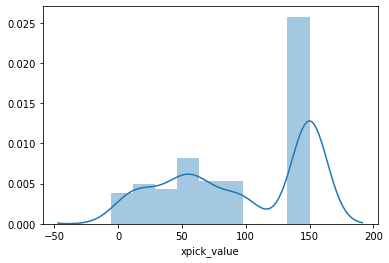

In [1165]:
sns.distplot(df.loc[df.position == 'F', 'xpick_value'])

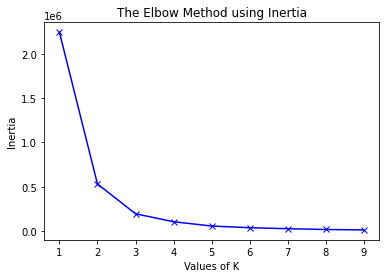

In [1246]:
from sklearn.cluster import KMeans
from sklearn import metrics 
from scipy.spatial.distance import cdist 
import numpy as np 
import matplotlib.pyplot as plt 

distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
  
dims = ['nhl_expected_value', 'xpick_value']
position = 'D'

X = df.loc[df.position == position,dims]

for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(X) 
    kmeanModel.fit(X)     
      
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / X.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / X.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 
    
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

In [1247]:
# k = 3 to 5
kmeans = KMeans(n_clusters=7).fit(X) 
kmeans.fit(X)

# forwards['cluster'] = kmeans.predict(forwards[['nhl_expected_value', 'xvalue_percentile']])
df.loc[df.position == position ,['cluster']] = kmeans.predict(df.loc[df.position == position, dims])


In [1248]:
px.scatter(data_frame=df.loc[df.position == position],
           x='xpick_value',
           y='nhl_expected_value',
           color='cluster',
           hover_name = 'player_name'
          )

In [1249]:
px.scatter(data_frame=df.loc[df.position == position],
           x='draft_pick',
           y='nhl_expected_value',
           color='cluster',
           hover_name = 'player_name'
          )

In [1250]:
draft_value = df.loc[df.position == position].groupby(['cluster']).agg({
                'xpick_value' : ['min', 'max', 'mean', 'std'],
                'draft_pick' : ['min', 'max', 'mean', 'std'],
                'nhl_expected_value' : 'mean', 
                'nhl_ceiling' : 'mean',
                'draft_plus_5_points' : 'mean',
                'playerid' : 'count'
            }
            ).sort_values([('nhl_expected_value', 'mean')])

draft_value[('playerid', 'count')] /= draft_value[('playerid', 'count')].sum()

draft_value.columns = draft_value.columns.set_levels(['Pick Value', 'Draft Pick', 'xValue', 'Upside', 'Scoring', '# of Players'], level=0)

In [1251]:
draft_value

Pick Value                                   Draft Pick                                  xValue      Upside     Scoring # of Players
                min         max        mean       std        min  max        mean        std        mean        mean        mean        count
cluster                                                                                                                                      
1.0      150.000000  150.000000  150.000000  0.000000         32  213  132.076023  50.682730    0.207602   12.789474    2.636116     0.506667
4.0       98.974318   98.974318   98.974318  0.000000         20  210  127.245614  54.784083    2.000000   32.614035    1.674964     0.084444
0.0       50.802805   78.075819   63.410644  8.850334         12  211  103.811594  53.354557    5.152174   41.000000    4.871375     0.204444
6.0       27.861949   48.155268   39.068938  6.508009         11  212   69.836364  46.923012   14.527273   60.309091   11.531940     0.081481
2.0       12.947464   25.552268   18.676621  3.764874          1   67   24.375000  15.473198   39.250000   98.100000   30.137827     0.059259
5.0        3.237491   11.541625    7.569011  2.521109          2   23   10.214286   6.261920   69.714286  116.071429   51.953997     0.041481
3.0       -6.691542    2.601596   -0.878370  3.048756          1   20    8.733333   6.419464  109.800000  159.733333  113.496567     0.022222

In [1252]:
['Top 5', 'Top 15', '1st Round', '2nd round', '3rd Round', 'Mid Round', 'Late Round']

['Top 5',
 'Top 15',
 '1st Round',
 '2nd round',
 '3rd Round',
 'Mid Round',
 'Late Round']

### Player ceiling for upside

In [1194]:
df.head()

,playerid,league,gp,g,a,tp,real_season_age,draft_plus_5_points,draft_plus_5_gp,player_name,position,height,weight,shoots,draft_year,draft_pick,draft_round,nhl_likelihood,nhl_ceiling,nhl_floor,most_likely_nhl_prob,nhl_ceiling_prob,nhl_expected_value,primary_position,xvalue_percentile,ceiling_percentile,apple_rank,nhl_rank,picks,pick_value,xpick_value,ppg,upside,cluster
0,3856,SuperElit,40.0,3.0,10.0,13.0,19.7,0.0,0.0,Daniel Rahimi,D,"6' 2""",215,L,2006,82,3,0.01,28.0,28,0.01,0.01,0,D,43.833068,93.673578,20,10,1,NaN,150.0,NaN,NaN,NaN
1,3724,SuperElit,36.0,5.0,6.0,11.0,18.7,0.0,0.0,Niclas Andersén,D,"6' 0""",209,L,2006,114,4,0.05,33.0,14,0.01,0.00,1,D,87.666135,94.364700,19,10,1,NaN,150.0,NaN,NaN,NaN
2,15452,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Jordan Fulton,F,"6' 0""",193,L,2006,179,6,0.00,0.0,0,1.00,1.00,0,F,42.872180,42.872180,38,38,1,NaN,150.0,NaN,5.0,0.0
3,12261,NCAA,38.0,2.0,2.0,4.0,21.0,0.0,0.0,Chris Frank,D,"6' 1""",228,L,2006,188,7,0.00,0.0,0,1.00,1.00,0,D,43.833068,43.833068,20,10,1,NaN,150.0,NaN,NaN,NaN
4,12278,USHL,59.0,10.0,12.0,22.0,18.7,0.0,1.0,Shane Sims,D,"6' 0""",195,R,2006,126,5,0.00,0.0,0,1.00,1.00,0,D,43.833068,43.833068,20,10,1,NaN,150.0,0.0,NaN,NaN


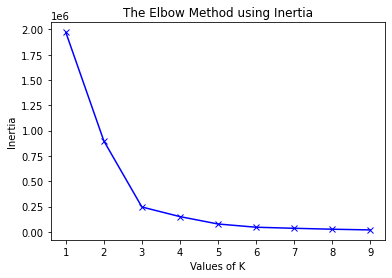

In [1366]:
from sklearn.cluster import KMeans
from sklearn import metrics 
from scipy.spatial.distance import cdist 
import numpy as np 
import matplotlib.pyplot as plt 

distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
  
dims = ['nhl_ceiling', 'ceiling_percentile']
X = df.loc[df.position == position, dims]

for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(X) 
    kmeanModel.fit(X)     
      
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / X.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / X.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 
    
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

# k = 3 to 5
kmeans = KMeans(n_clusters=6).fit(X) 
kmeans.fit(X)

df.loc[df.position == position ,['upside']] = kmeans.predict(df.loc[df.position == position, dims])

In [1367]:
px.scatter(data_frame=df[df.position == position],
          y='nhl_ceiling',
          x='xpick_value',
          hover_data = ['player_name'],
           color='upside'
          )

In [1368]:
px.scatter(data_frame=df[df.position == position],
          y='nhl_ceiling',
          x='draft_pick',
          hover_data = ['player_name'],
           color='upside'
          )

In [1371]:
df.head()

,playerid,league,gp,g,a,tp,real_season_age,draft_plus_5_points,draft_plus_5_gp,player_name,position,height,weight,shoots,draft_year,draft_pick,draft_round,nhl_likelihood,nhl_ceiling,nhl_floor,most_likely_nhl_prob,nhl_ceiling_prob,nhl_expected_value,primary_position,xvalue_percentile,ceiling_percentile,xpick_value,value_cluster,upside_cluster,draft_value_range,draft_upside,historical_rank,upside
2,15452,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Jordan Fulton,F,"6' 0""",193,L,2006.0,179,6,0.00,0.0,0,1.00,1.00,0,F,42.87218,42.872180,150.0,1,1,Late Round,Unknown,1551,NaN
7,9592,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Alexander Bumagin,F,"5' 11""",191,L,2006.0,170,6,0.00,0.0,0,1.00,1.00,0,F,42.87218,42.872180,150.0,1,1,Late Round,Unknown,1551,NaN
8,11419,NCAA,36.0,6.0,28.0,34.0,20.4,0.0,0.0,Erik Condra,F,"5' 10""",187,R,2006.0,211,7,0.03,25.0,24,0.03,0.03,0,F,42.87218,90.285714,150.0,1,1,Late Round,Unknown,1551,NaN
9,9286,Czech,45.0,6.0,4.0,10.0,19.0,0.0,0.0,David Kveton,F,"5' 10""",184,L,2006.0,104,4,0.02,43.0,19,0.02,0.01,0,F,42.87218,92.421053,150.0,1,5,Late Round,Project,1551,NaN
10,8394,Jr. A SM-liiga,24.0,3.0,10.0,13.0,18.6,0.0,0.0,Max Wärn,F,"6' 1""",206,L,2006.0,150,5,0.02,47.0,19,0.02,0.00,0,F,42.87218,92.721805,150.0,1,5,Late Round,Project,1551,NaN


In [1369]:
draft_upside = df.loc[df.position == position].groupby(['upside']).agg({
                'xpick_value' : ['min', 'max', 'mean', 'std'],
                'draft_pick' : ['min', 'max', 'mean', 'std'],
                'nhl_expected_value' : 'mean', 
                'nhl_ceiling' : 'mean',
                'draft_plus_5_points' : 'mean',
                'playerid' : 'count'
            }
            ).sort_values([('nhl_expected_value', 'mean')])

draft_upside[('playerid', 'count')] /= draft_upside[('playerid', 'count')].sum()

draft_upside.columns = draft_upside.columns.set_levels(['Pick Value', 'Draft Pick', 'xValue', 'Upside', 'Scoring', '# of Players'], level=0)

DataError: No numeric types to aggregate

In [1370]:
draft_upside

Pick Value                                    Draft Pick                                  xValue      Upside    Scoring # of Players
               min         max        mean        std        min  max        mean        std        mean        mean       mean        count
upside                                                                                                                                      
2.0     150.000000  150.000000  150.000000   0.000000         38  213  146.614458  44.851494    0.000000    0.000000   1.473513     0.245926
0.0      98.974318  150.000000  146.317734  13.272038         35  211  122.432990  52.725292    0.257732   16.721649   2.250117     0.143704
3.0      40.254067  150.000000   96.356988  39.767135         12  212  110.472868  53.783914    3.434109   34.298450   4.873527     0.382222
5.0      17.951717  150.000000   53.484419  31.131608          8  206   79.855072  53.307453   12.623188   63.217391   9.913837     0.102222
1.0      -0.812172   57.613560   16.673213  11.422352          1  189   23.632353  27.174892   49.073529  105.117647  39.316869     0.100741
4.0      -6.691542    8.434855    0.570090   4.088114          1   20    8.764706   6.647644  102.647059  164.529412  93.433421     0.025185

In [1016]:
['Top End', 'High End', 'Mid End', 'Safe', 'Project', 'Unknown']

### Analyze draft picks

In [471]:
forwards = drafted[drafted.position == 'F']

forwards = forwards.merge(draft_plus5[['playerid', 'draft_plus_5_points']], 
                          
                        on = 'playerid')

forwards['xpick_value'] = inverse_exp(forwards.nhl_expected_value, *popt_)
forwards['xpick_value'] = forwards['xpick_value'].fillna(150)
forwards['pick_value'] = inverse_exp(forwards.draft_plus_5_points, *popt)
forwards['pick_value'] = forwards['pick_value'].fillna(150)

In [473]:
forwards.head()

,playerid,league,gp,g,a,tp,height,weight,shoots,real_season_age,draft_year,draft_pick,draft_round,player_name,position,nhl_likelihood,nhl_ceiling,nhl_floor,most_likely_nhl_prob,nhl_ceiling_prob,nhl_expected_value,primary_position,xvalue_percentile,ceiling_percentile,draft_plus_5_points,xpick_value,pick_value
0,9326,OHL,58.0,62.0,83.0,145.0,"5' 10""",176,L,19.1,2007,1,1,Patrick Kane,F,1.00,380.0,380.0,0.73,0.73,327.0,F,99.699248,99.849624,400.871305,-5.805024,-3.040493
1,10425,OHL,53.0,35.0,83.0,118.0,"5' 10""",200,R,18.4,2007,6,1,Sam Gagner,F,1.00,313.0,313.0,0.70,0.70,283.0,F,99.398496,99.639098,239.443590,-3.500785,2.280404
2,11109,OHL,54.0,26.0,52.0,78.0,"6' 0""",204,L,18.8,2007,9,1,Logan Couture,F,0.99,232.0,177.0,0.70,0.11,167.0,F,98.255639,99.067669,133.960245,4.938888,8.361817
3,9285,QMJHL,59.0,23.0,63.0,86.0,"6' 2""",213,L,18.4,2007,7,1,Jakub Voracek,F,0.99,257.0,163.0,0.72,0.13,163.0,F,98.195489,99.248120,198.866133,5.328214,4.212516
4,11345,BCHL,53.0,66.0,55.0,121.0,"6' 0""",189,R,18.4,2007,3,1,Kyle Turris,F,0.96,291.0,183.0,0.49,0.15,159.0,F,98.045113,99.458647,80.749969,5.727369,13.791860


In [ ]:
import plotly.express as px

fig = px.scatter(df,
                 x="nhl_expected_value",
                 y="draft_plus_5_points", 
                 facet_col='position',
                 trendline="ols",
                 color='position',
                 size='nhl_ceiling_prob',
                 hover_data=['player_name'],
#                 width=1000
                )

fig.update_yaxes(mirror=False)
fig.show()

### Draft pick value

In [27]:
# load database credentials and create connection
user, password, server, database = load_db_credentials()
engine = create_engine(f'postgresql://{user}:{password}@{server}:5432/{database}')

player_value = pd.read_sql(f'''select * from summary_projections where draft_year <= 2015 and base_year = 'DY' ''', con=engine)


In [240]:
draft_elg = dataset[(dataset.end_year == dataset.draft_year)]\
            .sort_values('end_year').drop_duplicates(subset=['playerid', 'player'])

draft_plus5['playerid'] = draft_plus5['playerid'].astype(int)
draft_elg['playerid'] = draft_elg['playerid'].astype(int)

In [241]:
df = player_value.merge(draft_plus5,
                        how='left',
                        left_on = ['playerid', 'player_name', 'position'],
                        right_on = ['playerid', 'player', 'primary_position'])

In [242]:
df = df.merge(draft_elg[['playerid', 'league', 'height', 'weight', 'shoots', 'real_season_age']],
              on ='playerid')

In [243]:
df['xgp'] = player_value.apply(get_expected_gp, axis=1)

In [244]:
df['xppg'] = df.nhl_expected_value / df.xgp.replace(0, 1)
df['ppg'] = df.draft_plus_5_points / df.gp.replace(0, 1)

In [245]:
df['ppg'] = df['ppg'].fillna(0)
df['xppg'] = df['xppg'].fillna(0)

In [246]:
df['gp'] = df['gp'].fillna(0)
df['draft_plus_5_points'] = df['draft_plus_5_points'].fillna(0)

df['points_above_expected'] = df.draft_plus_5_points - df.nhl_expected_value

In [247]:
df['nhl_expected_value'] = df['nhl_expected_value'].astype(int)

df['primary_position'] = df.position

df['xvalue_percentile'] = df.apply(get_value_rank, axis=1)

df['historical_rank'] = df['xvalue_percentile'].rank(ascending=False).astype(int)

df.sort_values('historical_rank', inplace=True)


In [64]:
def load_player_data(playerid):

    player_value = pd.read_sql(f'''select * from summary_projections where playerid = '{playerid}' ''', con=engine)

    projections = pd.read_sql(f'''select * from projections where playerid = '{playerid}' ''', con=engine)

    player_df = dataset[dataset.playerid == str(playerid)]
    start_age = player_df.season_age.max()
    position = get_primary_position(player_df.position.iloc[0])
    player_name = player_df.player.iloc[0]

    try:
        G = json_graph.node_link_graph(json.loads(player_value['graph'].item()))
        
    except:
        G = json_graph.node_link_graph(json.loads(player_value['graph']))

    return G, projections, player_df, start_age, position, player_name, player_value

from networkx.drawing.nx_agraph import graphviz_layout

def custom_plotly_colorscale(c, bins=7):

    h = 1.0/(bins-1)
    pl_colorscale = []
    
    for k in range(bins):
        pl_colorscale.append([k*h, 'rgb'+str((c[k][0]*255, c[k][1]*255, c[k][2]*255))])
        
    return pl_colorscale


def get_development_graph(df, G, position, player_name):
    
    # create tree layout and rescale based on age
    pos = graphviz_layout(G, prog='dot')
    # array of ages for y-axis
    ages = np.arange(min([int(G.nodes[node]['age']) for node in G.nodes]),
                 max([int(G.nodes[node]['age']) for node in G.nodes]) + 1,
                 1)
    # rescale x,y coordinates
    y = np.array([xy[1] for _, xy in pos.items()])
    y_rescale = (y.max() / y.min()) / (ages.max() / ages.min())
    y_map = { k:v for k,v in zip(sorted(np.unique(y))[::-1], ages)}
    pos = {u :(v[0] / y_rescale, y_map[v[1]]) for u,v in pos.items()}
    
    edge_labels = nx.get_edge_attributes(G, 'probability')
    
    node_trace = go.Scatter(
        x=[pos[node][0] for node in G.nodes()],
        y=[pos[node][1] for node in G.nodes()],
        mode='markers+text',
        text=["<b>" + G.nodes[g]['league'] for g in G.nodes],
        hovertemplate=
            "</b><b>%{customdata[1]}</b><br><br>" +
            "Age: <b>%{y:,.0f}</b><br>" +
            "League: %{text}</b><br>" +
            "PPG: <b>%{customdata[0]:,}</b>" +
            "<extra></extra>",
        customdata=[(round(G.nodes[g]['ppg'], 2), 
                     G.nodes[g]['role'])  for g in G.nodes],
        textposition='middle center',
        showlegend=True,
        textfont=dict(size=14,),
        marker=dict(
#             color=[f'rgba(0, 116, 255, {d})' for d in d],
#             color=[G.nodes[g]['role_rank']  for g in G.nodes],
            color=discrete_marker_color(df, G, position, n_bins=5),
            size= [30 for g in G.nodes],
            cmax=100,
            cmin=0,
            cmid=50,
            colorbar=dict(
                title="<b>Scoring Role<b> <br />",
                titleside="top",
                ticks='outside',
                showticklabels=True,
                tickvals=f_role_perc[:-1]  if position == 'F' else d_role_perc[:-1],
                ticktext=f_role_labels if position == 'F' else d_role_labels
            ),
            colorscale=custom_plotly_colorscale(sns.diverging_palette(40, 218, s=72, l=69, sep=1 , n=5), 5)
            )
    )

    legend = go.Scatter(x=[None], y=[None],
                       marker=dict(
            size=0,
            cmax=1,
            cmin=0,
            color=[0,1],
            colorbar=dict(
                title="<b>Transition %<b> <br />",
                titleside="top",
            ),
            colorscale="Greys"
        ),
                        showlegend=True,
        mode="markers")

    fig = go.Figure(data=[node_trace, ],
                 layout=go.Layout(
                     height=600,
                     width=900,
                     font=dict(family='overpass, monospace') , 
                    title=f"<b>{player_name} Player Development</b>",
                    titlefont_size=18,
                     title_x=0.5,
                     plot_bgcolor='rgb(255,255,255)',
                     paper_bgcolor='rgba(0,0,0,0)',
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20,l=5,r=5,t=40),
                    annotations=[ dict(
                        text="By: Connor Jung <a href='https://twitter.com/ConnorJungle'>@ConnorJungle</a> Data Source: Elite Prospects",
                        showarrow=False,
                        xref="paper", yref="paper",
                        x=0.005, y=-0.005 ) ],
                     yaxis=dict(title='<b>Season Age</b>', showline=True, linewidth=2, linecolor='black', mirror=True, tickvals=ages),
                    xaxis=dict(showticklabels=False, title='MeaningleX Axis', showline=True, linewidth=2, linecolor='black', mirror=True),
                 )
                   )

    for edge in G.edges():

        fig.add_annotation(
          x=(pos[edge[1]][0] + pos[edge[0]][0]) / 2,  # arrows' tail
          y=(pos[edge[1]][1] + pos[edge[0]][1]) / 2,  # arrows' tail
    #         xanchor="right",
    #         yanchor="bottom",
            showarrow=False,
            bordercolor="lightslategrey",
            borderwidth=2,
            borderpad=1,
          text= "{:.0%}".format(edge_labels[edge])
        )

        fig.add_annotation(
          x=pos[edge[1]][0],  # arrows' head
          y=pos[edge[1]][1],  # arrows' head
          ax=pos[edge[0]][0],  # arrows' tail
          ay=pos[edge[0]][1],  # arrows' tail
          xref='x1',
          yref='y1',
          axref='x1',
          ayref='y1',
            opacity=0.3,
          showarrow=True,
          arrowhead=3,
          arrowsize=1,
          arrowwidth=3,
          arrowcolor='lightslategrey',
            standoff = 15
        )

    for y in np.unique([v[1] for k,v in pos.items()]):
        fig.add_shape(
                # Line Horizontal
                    type="line",
                    y0=y,
                    x1=max([v[0] for k,v in pos.items()]) + (max([v[0] for k,v in pos.items()]) * 0.10) ,
                    x0=min([v[0] for k,v in pos.items()]) - (max([v[0] for k,v in pos.items()]) * 0.10) ,
                    y1=y,
                    layer='below',
                    line=dict(
                        color="rgba(212, 212, 212, 1)",
                        width=2,
                        dash="dashdot",
                    ))

    
    return fig

def discrete_background_color_bins(df, position, n_bins=5, columns='all', group='league'):

#     bounds = [i * (1.0 / n_bins) for i in range(n_bins + 1)]
    bounds = [i / 100 for i in f_role_perc]  if position == 'F'\
        else [i / 100 for i in d_role_perc] 

    if columns == 'all':
        if 'id' in df:
            df_numeric_columns = df.select_dtypes('number').drop(['id'], axis=1)
        else:
            df_numeric_columns = df.select_dtypes('number')
    else:
        df_numeric_columns = df[columns]

    styles = []
    legend = []
    
    for league in df[group].unique():
        
        subset = df[df.league == league]

        for column in df_numeric_columns:

            for i in range(1, len(bounds)):
                min_bound = np.percentile(subset[column], bounds[i - 1] * 100)
                max_bound = np.percentile(subset[column], bounds[i] * 100)
                backgroundColor = custom_plotly_colorscale(sns.diverging_palette(40, 218, s=72, l=69, n=n_bins), n_bins)[i - 1][1]
                color = 'black' 

                styles.append({
                    'if': {
                        'filter_query': (
                            '{{league}} = "{league_name}"  && ' + 
                            '{{{column}}} >= {min_bound}' +
                            (' && {{{column}}} < {max_bound}' if (i < len(bounds) - 1) else '')
                        ).format(league_name=league, column=column, min_bound=min_bound, max_bound=max_bound),
                        'column_id': column
                    },
                    'backgroundColor': backgroundColor,
                    'color': color,
                })

                legend.append(
                    html.Div(style={'display': 'inline-block', 'width': '60px'}, children=[
                        html.Div(
                            style={
                                'backgroundColor': backgroundColor,
                                'borderLeft': '1px rgb(50, 50, 50) solid',
                                'height': '10px',
                            }
                        ),
                        html.Small(round(bounds[i - 1] * 100), style={'paddingLeft': '2px'})
                    ])
                )

    return (styles, html.Div(legend, style={'padding': '5px 0 5px 0'}))


def discrete_marker_color(df, G, position, n_bins=7):
    
    c = custom_plotly_colorscale(sns.diverging_palette(40, 218, s=72, l=69, n=n_bins), n_bins)

#     bounds = [i * (1.0 / n_bins) for i in range(n_bins + 1)]
    bounds = [i / 100 for i in f_role_perc]  if position == 'F'\
        else [i / 100 for i in d_role_perc] 

    styles = []
    
    for node in G.nodes:
        subset = df[df.league == G.nodes[node]['league']]
        
        ranges = [(
            np.percentile(subset['ppg'], bounds[i - 1] * 100),
            np.percentile(subset['ppg'], bounds[i] * 100)) for i in range(1, len(bounds))]

        styles.append(c[between_two_values(ranges, G.nodes[node]['ppg'])][1])

    return styles


def between_two_values(lst, value):

    for i, (min_val, max_val) in enumerate(lst):
        if min_val <= value < max_val:
            return i
    return i

table_metrics = {'g' : 'G',
                 'a' : 'A', 
                 'tp' : 'PTS', 
                 'gpg' : 'GPG',
                 'apg' : 'APG',
                 'ppg' : 'PPG', }

stat_columns = {'year' : 'Year',
              'league' : 'League', 
              'season_age' : 'Age', 
              'gp' : 'GP' }

proj_columns = {'probability' : 'Probability', 
               'league' : 'League',
               'season_age' : 'Age', 
               'gp' : 'GP' }


f_role_labels = ['Depth', 'Top 9', 'Top 6', 'Top Line', 'Elite']
d_role_labels = ['Depth', 'Top 6', 'Top 4', 'Top Pair', 'Elite']

f_role_perc = [0, 29, 49, 74, 94, 100] 
d_role_perc = [0, 19 ,49, 69, 89, 100]


In [1314]:
G, projections, player_df, start_age, position, player_name, player_value = load_player_data(62204)

In [ ]:
get_development_graph(dataset, G, position, player_name)

In [454]:
gp_mean = dataset[(dataset.gp < 85)
                  & (dataset.season_age >= 17)
                  & ~(team_mask)
                  & (dataset.season_age <= 24)].groupby('league').gp.median().round().to_dict()


In [417]:
gp_mean

{'AHL': 55.0,
 'AJHL': 50.0,
 'Allsvenskan': 43.0,
 'BCHL': 51.0,
 'CCHL': 48.0,
 'Czech': 39.0,
 'Czech2': 34.0,
 'Jr. A SM-liiga': 36.0,
 'KHL': 38.0,
 'Liiga': 45.0,
 'MHL': 43.0,
 'NCAA': 33.0,
 'NHL': 68.0,
 'NLA': 40.0,
 'OHL': 59.0,
 'OJHL': 46.0,
 'QMJHL': 58.0,
 'SHL': 46.0,
 'SJHL': 47.0,
 'SuperElit': 37.0,
 'USHL': 50.0,
 'VHL': 37.0,
 'WHL': 61.0}

### Dash

In [1318]:
drafted.xvalue_percentile

2      42.872180
7      42.872180
8      42.872180
9      42.872180
10     42.872180
         ...    
165    43.833068
173    88.144604
176    87.666135
181    95.002658
184    43.833068
Name: xvalue_percentile, Length: 1866, dtype: float64

In [1320]:
drafted = pd.concat([fwd, def_])
drafted['historical_rank'] = drafted.groupby('position')['xvalue_percentile'].rank(ascending=False).astype(int)

2      1038
7      1038
8      1038
9      1038
10     1038
       ... 
165     540
173     237
176     369
181      65
184     540
Name: historical_rank, Length: 1866, dtype: int64

In [1331]:
drafted.to_csv('../data/draft-rankings-v2.csv')

In [1332]:
df = pd.read_csv('../data/draft-rankings-v2.csv')

In [1335]:
df.head()

,Unnamed: 0,playerid,league,gp,g,a,tp,real_season_age,draft_plus_5_points,draft_plus_5_gp,player_name,position,height,weight,shoots,draft_year,draft_pick,draft_round,nhl_likelihood,nhl_ceiling,nhl_floor,most_likely_nhl_prob,nhl_ceiling_prob,nhl_expected_value,primary_position,xvalue_percentile,ceiling_percentile,apple_rank,nhl_rank,picks,pick_value,xpick_value,ppg,upside,cluster,value_cluster,upside_cluster,draft_value_range,draft_upside,historical_rank
0,2,15452,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Jordan Fulton,F,"6' 0""",193,L,2006,179,6,0.00,0.0,0,1.00,1.00,0,F,42.87218,42.872180,38,38,1,NaN,150.0,NaN,0.0,0.0,1,1,Late Round,Unknown,1038
1,7,9592,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Alexander Bumagin,F,"5' 11""",191,L,2006,170,6,0.00,0.0,0,1.00,1.00,0,F,42.87218,42.872180,38,38,1,NaN,150.0,NaN,0.0,0.0,1,1,Late Round,Unknown,1038
2,8,11419,NCAA,36.0,6.0,28.0,34.0,20.4,0.0,0.0,Erik Condra,F,"5' 10""",187,R,2006,211,7,0.03,25.0,24,0.03,0.03,0,F,42.87218,90.285714,38,38,1,NaN,150.0,NaN,4.0,0.0,1,5,Late Round,Project,1038
3,9,9286,Czech,45.0,6.0,4.0,10.0,19.0,0.0,0.0,David Kveton,F,"5' 10""",184,L,2006,104,4,0.02,43.0,19,0.02,0.01,0,F,42.87218,92.421053,38,38,1,NaN,150.0,NaN,2.0,0.0,1,2,Late Round,Safe,1038
4,10,8394,Jr. A SM-liiga,24.0,3.0,10.0,13.0,18.6,0.0,0.0,Max Wärn,F,"6' 1""",206,L,2006,150,5,0.02,47.0,19,0.02,0.00,0,F,42.87218,92.721805,38,38,1,NaN,150.0,NaN,2.0,0.0,1,3,Late Round,Mid End,1038


In [1338]:
import dash_table.FormatTemplate as FormatTemplate

table_cols = [{'id' : 'historical_rank', 'name' : 'APPLE Rank'},
              {"id": "player_name", "name": "Player"} ,
              {"id": 'draft_year', "name" : "Draft"}, 
              {"id": 'draft_round', "name" : "Round"}, 
              {"id": "draft_pick", "name": "Pick"} ,
              {"id": "position", "name": "Pos"} ,
              {"id": 'real_season_age', "name" : "Age"}, 
              {"id": 'height', "name" : "Height"}, 
              {"id": 'weight', "name" : "Weight"}, 
              {"id": 'shoots', "name" : "Shoots"}, 
              {"id": 'league', "name" : "League"}, 
              {'id' : 'draft_value_range', "name" : "Draft Range"},
              {"id" : 'draft_upside', "name" : 'Upside'},
              {"id": "apple_rank", "name": "Pick Value", 'type': 'numeric'} ,
              {"id": "nhl_ceiling", "name": "NHL Ceiling", 'type': 'numeric'} ,
              {"id": "nhl_expected_value", "name": "xNHL Points"}]

col_order = ['historical_rank', 'player_name', 'draft_year',
             'draft_round', "draft_pick",'position', 'real_season_age',
'height', 'weight', 'shoots', 'league', 'draft_value_range',
'draft_upside',  'xpick_value', 
'nhl_floor', 'nhl_ceiling', 'nhl_expected_value']

(styles, _) = rankings_background_color_bins(df, n_bins=100, columns=[
                                                             'nhl_ceiling',
                                                             'nhl_expected_value'])

(styles_, _) = rankings_background_color_bins(df, n_bins=100, columns=['real_season_age'], ascending=True)

(_, legend) = legend_background_color_bins(pd.DataFrame([i for i in range(1,101)],
                                                          columns=['percentile']),
                                             columns=['percentile'], n_bins=11)

In [1339]:
app = JupyterDash(__name__)
app.layout = html.Div([
    legend,
    dash_table.DataTable(
        id='draft-rankings',
        columns=table_cols,
        data=df.sort_values('historical_rank').to_dict('records'),
        style_data_conditional=styles + styles_,
        style_cell={'textAlign': 'center',
                    "border": "4px solid white",
                    'width': '90px',
                    'whiteSpace' : 'normal',
                   },
        sort_action="native",
        sort_mode="multi",
        style_header={
            'backgroundColor': 'rgb(230, 230, 230)',
            'fontWeight': 'bold'
        },
        tooltip={'nhl_likelihood': {'type': 'text', 'value': 'Likelihood to play NHL Games by Draft + 5'},
                'most_likely_nhl_prob': {'type': 'text', 'value': 'Likelihood to reach NHL Floor by Draft + 5'},
                'nhl_ceiling_prob': {'type': 'text', 'value': 'Likelihood to reach NHL Ceiling by Draft + 5'},
                'nhl_expected_value': {'type': 'text', 'value': 'Expected Cumulative NHL Points up to Draft + 5'}}
    )
                       ]
                      )

if __name__ == '__main__':
    app.run_server(mode='inline', port='8777')

# Team Evaluation

### Actual vs. Expected Points

### Number of Players to play 50,100,150,200,250,300 games

### Number of Players by scoring role (actual vs. expected) (Lolipop?, facet by position) 

### Standardize by pick position 

### Draft + Develop vs. Trade + Develop

In [71]:
import seaborn as sns

In [72]:
df.head()

,playerid,player_name,position,nhl_likelihood,most_likely_nhl_node,most_likely_nhl_prob,nhl_floor,nhl_expected_value,nhl_ceiling,nhl_maximizing_node,nhl_ceiling_prob,graph,date_of_birth,draft_year,player,primary_position,draft_plus_5_points,gp,league,height,weight,shoots,real_season_age,xgp,xppg,ppg,points_above_expected,historical_percentile,historical_rank
138,9326,Patrick Kane,F,1.00,6,1.00,450.9,450,451.0,6,1.00,"{""directed"": true, ""multigraph"": false, ""graph...",1988-11-19,2007.0,Patrick Kane,F,401.308733,399.0,OHL,178.0,80.0,L,19.11,410,1.099756,1.005786,-49.591267,99.507389,1
283,9878,Erik Karlsson,D,0.99,20,0.51,170.1,179,226.0,21,0.32,"{""directed"": true, ""multigraph"": false, ""graph...",1990-05-31,2008.0,Erik Karlsson,D,164.777607,216.0,SuperElit,182.0,87.0,R,18.59,22,8.150000,0.762859,-14.522393,98.469388,2
368,9223,John Tavares,F,1.00,6,1.00,340.6,340,341.0,6,1.00,"{""directed"": true, ""multigraph"": false, ""graph...",1990-09-20,2009.0,John Tavares,F,348.039331,350.0,OHL,185.0,94.0,L,19.28,381,0.893963,0.994398,7.439331,98.029557,3
4,3682,Nicklas Bäckström,F,1.00,13,0.51,403.2,336,403.0,13,0.51,"{""directed"": true, ""multigraph"": false, ""graph...",1987-11-23,2006.0,Nicklas Bäckström,F,348.014572,323.0,SHL,184.0,97.0,L,19.11,354,0.949153,1.077444,12.014572,98.029557,3
220,10425,Sam Gagner,F,1.00,17,0.85,325.1,300,325.0,17,0.85,"{""directed"": true, ""multigraph"": false, ""graph...",1989-08-10,2007.0,Sam Gagner,F,239.714750,366.0,OHL,180.0,91.0,R,18.39,42,7.145238,0.654958,-60.385250,96.551724,5


<AxesSubplot:xlabel='nhl_expected_value'>

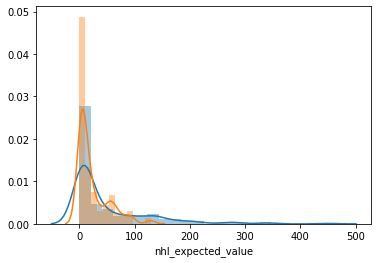

In [75]:
sns.distplot(df[(df.xgp >= 100)
                        & (df.primary_position == 'F')].nhl_expected_value)

sns.distplot(df[(df.xgp >= 100)
                        & (df.primary_position == 'D')].nhl_expected_value)

<AxesSubplot:xlabel='draft_plus_5_points'>

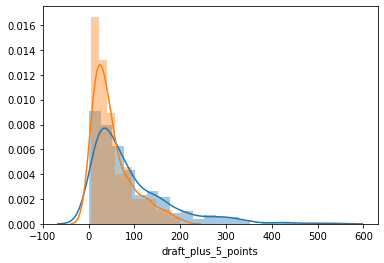

In [67]:
sns.distplot(draft_plus5[(draft_plus5.gp >= 50)
                        & (draft_plus5.primary_position == 'F')].draft_plus_5_points)

sns.distplot(draft_plus5[(draft_plus5.gp >= 50)
                        & (draft_plus5.primary_position == 'D')].draft_plus_5_points)

NameError: name 'plt' is not defined

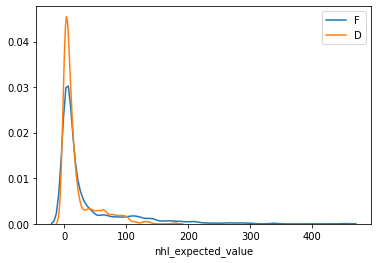

In [68]:
sns.distplot(df[df.primary_position == 'F'].nhl_expected_value, hist=False, label='F')
sns.distplot(df[df.primary_position == 'D'].nhl_expected_value, hist=False, label='D')
plt.legend()

In [ ]:
np.percentile(df[df.primary_position == 'D'].nhl_expected_value, 50)

In [ ]:
np.percentile(draft_plus5[(draft_plus5.gp >= 10)
                        & (draft_plus5.primary_position == 'D')].draft_plus_5_points, 50)